# The search for allopatric speciation in the gut microbial communities of Tanganyikan cichlids

## An adventure in fish poo.

*Russell Neches*

### Gut community structure in fish, and cichlids in particular


Here are some papers that examine the gut microbiome of fish, including
African cichlids.

* [Bacterial community structure in the intestinal ecosystem of rainbow trout (Oncorhynchus mykiss) as revealed by pyrosequencing-based analysis of 16S rRNA genes](http://dx.doi.org/10.1016/j.rvsc.2015.03.026). *Research in veterinary science*, Vol. 100 (June 2015), pp. 8-11 by Miray Etyemez, José Luis L. Balcázar

* [Perturbation and restoration of the fathead minnow gut microbiome after low-level triclosan exposure](http://dx.doi.org/10.1186/s40168-015-0069-6). *Microbiome*, Vol. 3 (2015), by Adrienne B. Narrowe, Munira Albuthi-Lantz, Erin P. Smith, et al.

* [Gut Microbiota Dynamics during Dietary Shift in Eastern African Cichlid Fishes](http://dx.doi.org/10.1371/journal.pone.0127462). *PLoS ONE*, Vol. 10, No. 5. (15 May 2015), e0127462, by Laura Baldo, Joan L. Riera, Ave Tooming-Klunderud, Mar M. Albà, Walter Salzburger


### Build OTU table, sample metadata and host tree

After much frustration, I've decided to abandon [`QIIME`](http://qiime.org/)
in favor of a simpler, more direct approach. I think this approach will be 
more useful to researchers who are pursuing novel statistical and phylogenetic
treatments of community amplicon data. 

I use [`vsearch`](https://github.com/torognes/vsearch) to perform chimera
checking and to cluster the data into OTUs. This step goes a lot faster if
a reference database of full-length 16S genes is used (I suggest the 
[`SILVA SSU Ref`](http://www.arb-silva.de/download/arb-files/) database, 
but it probably doesn't matter very much which one is used). The rest of 
the analysis is reference-free, so there is perhaps an interest in running
the chimera checking step *de novo*.

Then I use [`ssu-align`](http://selab.janelia.org/software/ssu-align/) to build an
alignment of all cluster centroids. Those who are not targeting an rRNA gene
should use an alignment method appropriate to their gene(s) of interest, 
such as [`LAST`](http://last.cbrc.jp/) for protein coding genes. Then, I build
a maximum likelihood tree with [`RAxML`](https://github.com/stamatak/standard-RAxML).

This analysis assumes you already have a tree for the host organisms. For my
study, I'm using a subset of  [rate-smoothed mega-phylogeny of actinopterygiians by
Rabosky *et al.*](http://datadryad.org/resource/doi:10.5061/dryad.j4802/1)
with a few substitutions for sister taxa that were not available.

A table of OTU counts is then constructed as a `pandas` DataFrame. Next, we load the
sample metadata as a DataFrame, which we use to drop the control samples and the other
experiments, and to merge the OTU counts for samples that have the same host species.

Last, we use rpy2 to import the host phylogeny. This is silly, but all of the tests 
for phylogenetic signal are in R, so we need to have the host tree as an R object.

Questions :
* Co-diversivtion or reciprocal adaptation?

Required software :
* [`vsearch`](https://github.com/torognes/vsearch)
* [`ssu-align`](http://selab.janelia.org/software/ssu-align/)
* [`RAxML`](https://github.com/stamatak/standard-RAxML)

Required databases :
* [`SILVA SSU Ref`](http://www.arb-silva.de/download/arb-files/)

Required python packages :
* `pandas`
* `seaborn`
* `dendropy`
* `scikit-bio`
* `ete2`

Required R packages :
* `ape`
* `phytools`
* `phylobase`
* `adephylo`

### On phylogenetic signal

> The concept of phylogenetic signal is at the heart of most phylogenetic
> methods. From a statistical point of view, a phylogenetic signal is 
> defined by the non-null covariances (i.e., non-independence) among species.
> From a biological point of view, phylogenetic signal is a direct consequence
> of the evolution of traits and its form will depend on teh evolutionary
> mechanisms in action.
>
> Emmanuael Paradis, *Analysis of phylogenetics and evolution with R*, p. 236

### On cospeciation

One of the classic datasets for cospeciation methods is probably the paper by 
Hafner *et al.* from 1994 in which they look at the relationship between pocket
gophers and the lice that specialize. 

* [Hafner, M. S. et al. Disparate rates of molecular evolution in cospeciating hosts and parasites. *Science (New York, N.Y.)* (1994).](http://www.calpoly.edu/~bio/LMOE/pdfs/Hafner%20et%20al.%201994.pdf)

I was sort of interested in trying this randomization-based method by Balbuena 
*et al.*, but Michael Turelli thinks the method may be lousy ("*ad hoc*") and 
that null hypothesis (hosts and parasites independently evolving).

* [Balbuena, J. A., Míguez-Lozano, R. & Blasco-Costa, I. PACo: A novel procrustes application to cophylogenetic analysis. *PLoS ONE* (2013).](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0061048)

Turelli suggested this paper by Huelsenbeck *et al.* which uses a Bayesian
framework to analyze the same data. In this paper, the null hypothesis is that
host and parasite evolution is parallel, and they look for likely violations
(i.e., host-switching events).

* [Huelsenbeck, J. P., Rannala, B. & Larget, B. A bayesian framework for the analysis of cospeciation. *Evolution* (2000).](http://www.ncbi.nlm.nih.gov/pubmed/10937213)

Later on, I found that scikit-bio implements a function called [`hommola_cospeciation`](http://scikit-bio.org/docs/latest/generated/generated/skbio.stats.evolve.hommola_cospeciation.html), which led me to this paper :

* [A Permutation Test of Host–Parasite Cospeciation](http://dx.doi.org/10.1093/molbev/msp062). *Molecular Biology and Evolution*, Vol. 26, No. 7. (01 July 2009), pp. 1457-1468, by Kerstin Hommola, Judith E. Smith, Yang Qiu, Walter R. Gilks

Hommola *et al.* describe a method extends the 
[Mantel test](https://en.wikipedia.org/wiki/Mantel_test). The Mantel test
requires matrixes of identitil dimensions, and so when it is used for 
co-speciation, the two trees must have the same number of memembers. When
they don't, past studies have deleted or duplicated taxa, which results in
anomalous results (the paper makes a direct comparison to such methods).
To address this issue, Hommola *et al.* propose an approach that measures
correlations like the Mantel test, but does not require identical matrix
dimensions. They then couple this with a straightforward permutation test 
to estimate the significance of the correlations.

The null hypothesis being tested is that the two groups of organisms have
evolved independently, which seems appropriate when attempting to *identify*
examples of co-speciation among the organisms found in a microbiome. 

What we undertake here is to build a tree of all OTUs associated with our
fish. We then construct a link matrix from the OTU counts by applying a
threshold on relative abundance. Then, we traverse the OTU tree, generating
trees for each clade of OTUs, and subsetting the link matrix to the OTUs
present. Taken with the host phylogeny, the `hommola_cospeciation` method 
from `scikit-bio` is applied to these three pieces of data, yielding a 
Pearson's correlation and a *p*-value based on the permutation test for 
each clade of OTUs in the OTU tree.

This approach leaves natural history of the association unexplored. However,
now that we've used Hommola's test to reject most parts of the OTU tree, it
should be possible to apply Huelsenbeck *et al.* to the much smaller OTU 
clades that show statistically significant phylogenetic concordance. There
are other tests that may be intersting, though, such as the `TreeKO` method
implemented in [`ete2`](http://etetoolkit.org/docs/latest/tutorial/tutorial_phylogeny.html#treeko-splitting-gene-trees-into-species-trees) :

* [TreeKO: a duplication-aware algorithm for the comparison of phylogenetic trees](http://nar.oxfordjournals.org/content/39/10/e66.long) *Nucleic Acids Research*, Vol. 39, No. 10. (01 May 2011), pp. e66-e66, doi:10.1093/nar/gkr087 by Marina Marcet-Houben, Toni Gabaldón

In [1]:
%pylab inline
#%load_ext retina
%config InlineBackend.figure_format='retina'

Populating the interactive namespace from numpy and matplotlib


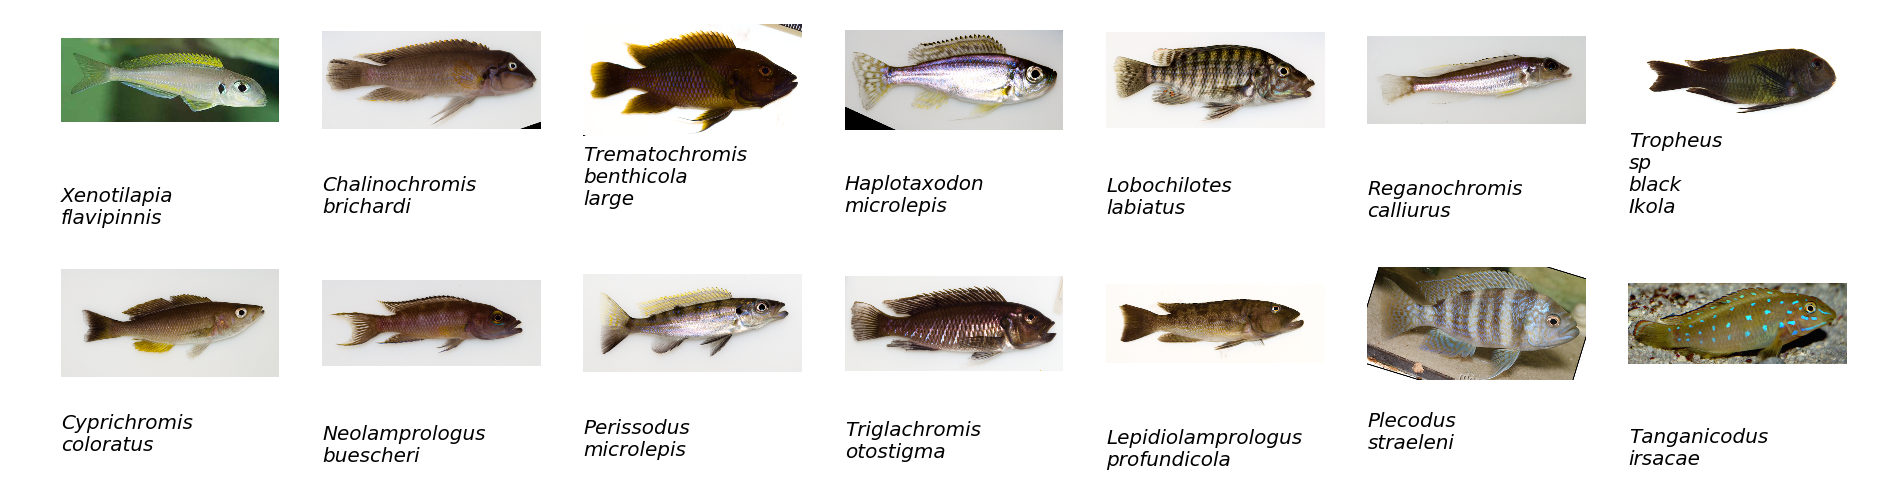

In [4]:
from IPython.display import display, Image
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

figure(figsize=(16, 4))

for root, _, files in os.walk('host_phenotypes') :
    for n,file in enumerate(files) :
        i =  mpimg.imread('host_phenotypes/' + file )
        subplot(2,7,n+1)
        plt.imshow(i)
        text( 0, 500, file.replace('_','\n').replace('.png',''), style='italic' )
        plt.axis('off')
        
#plt.tight_layout()

### Chimera detection, clustering and OTU counting

Here, we use [`vsearch`](https://zenodo.org/record/16153) to perform these tasks, 
and the [SILVA SSU reference database (release 123)](http://ftp.arb-silva.de/release_123/Exports/).

In [ ]:
!wget http://ftp.arb-silva.de/release_123/Exports/SILVA_123_SSURef_tax_silva_trunc.fasta.gz

In [ ]:
! vsearch --threads 48 --uchime_ref fishpoo.fasta.gz \
--db ../SILVA_123_SSURef_tax_silva_trunc.fasta.gz    \
--chimeras fishpoo_chimeras.fasta                    \
--nonchimeras fishpoo_nochimeras.fasta

! gzip fishpoo_chimeras.fasta
! gzip fishpoo_nochimeras.fasta

    vsearch v1.8.1_linux_x86_64, 47.2GB RAM, 16 cores
    https://github.com/torognes/vsearch
    
    Reading file ../SILVA_123_SSURef_tax_silva_trunc.fasta.gz 100%
    2489280089 nt in 1756783 seqs, min 900, max 3718, avg 1417
    Counting unique k-mers 100%
    Creating index of unique k-mers 100%
    Detecting chimeras 71%

In [ ]:
!vsearch --cluster_fast fishpoo_nochimeras.fasta.gz \
--id 0.99                                           \
--threads 16                                        \
--uc fishpoo.uc                                     \
--centroids fishpoo_centroids.fasta                 \
--consout fishpoo_consensus.fasta 

    vsearch v1.8.1_linux_x86_64, 47.2GB RAM, 16 cores
    https://github.com/torognes/vsearch
    
    Reading file fishpoo_nochimeras.fasta.gz 100%
    2011941945 nt in 7954947 seqs, min 106, max 509, avg 253
    Masking 100%
    Sorting by length 100%
    Counting unique k-mers 100%
    Clustering 100%
    Sorting clusters 100%
    Writing clusters 100%
    Clusters: 194733 Size min 1, max 3747815, avg 40.9
    Singletons: 141869, 1.8% of seqs, 72.9% of clusters
    Multiple alignments 100%

For parsing the [uclust-style clustering output](http://www.drive5.com/usearch/manual/ucout.html) :

* **H** : Hit. Represents a query-target alignment. For clustering, indicates the cluster assignment for the query. If ‑maxaccepts > 1, only there is only one H record giving the best hit. To get the other accepts, use another type of output file, or use the ‑uc_allhits option (requires version 6.0.217 or later).
* **S** : Centroid (clustering only). There is one S record for each cluster, this gives the centroid (representative) sequence label in the 9th field. Redundant with the C record; provided for backwards compatibility.
* **C**	: Cluster record (clustering only). The 3rd field is set to the cluster size (number of sequences in the cluster) and the 9th field is set to the label of the centroid sequence.

In [2]:
import gzip
import pandas as pd

OTUs = {}
for n,line in enumerate(gzip.open( 'fishpoo.uc.gz' )) :
    if line.split('\t')[0] == 'H' :
        # and also their hits
        hit, centroid = line.strip().split('\t')[8:10]
        hit = hit.split('_')[0]
        if not OTUs.has_key( centroid ) : OTUs[centroid] = [ centroid.split('_')[0] ]
        OTUs[centroid].append(hit)

In [3]:
# OTU list, sorted largest to smallest
otu_list = sorted(OTUs.keys(), key=lambda otu: len(OTUs[otu]))[::-1]
mapping = pd.DataFrame.from_csv('fishpoo_map.tsv', sep='\t')
otu_counts = pd.DataFrame( index=mapping.index )

for otu in otu_list :
    otu_counts[ otu ] = map( lambda x : OTUs[otu].count(x), otu_counts.index )

In [4]:
phase_1 = mapping[mapping.Experiment == 'Phase I']

# drop the samples that aren't fish
phase_1 = phase_1.drop(['KITCNT1', 'CHARCNT', 'WATERCNT', 'FOOD', 'Neg.Control.1'])

# Take the OTU counts for host taxa with more than one 
# individual, and merge them (basically, and inner join),
# and then normalize the OTU counts for each taxa to 1
otu_counts = pd.merge( otu_counts, 
                    pd.DataFrame(phase_1['Host']), 
                    right_index=True, 
                    left_index=True ).groupby('Host').sum()
otu_table = otu_counts.div( otu_counts.sum(axis=1), axis=0)

### Remove extremely rare OTUs

Remove the extremely rare OTUs and create a fasta file for the aligner.

In [5]:
non_rare_otus = []
for otu in otu_list :
    if sum(otu_table[otu])/14 > 0.00001 :
        non_rare_otus.append( otu )
print 'non-rare OTUs : ' + str(len( non_rare_otus ))

non-rare OTUs : 1844


In [8]:
otu_table[non_rare_otus].ix[0]

LEPIPRO1_18315      0.354188
PERIMIC1_17741      0.041353
CYPRCOL3_183759     0.339576
TRIGOTO3_27314      0.000129
TANGIRA.2_68563     0.013640
HAPMIC1.2_6014      0.008198
CYPRCOL6_85880      0.002907
TRIGOTO5_36588      0.007402
x0.45_3912          0.000000
HAPMIC6.2_59238     0.000000
TRIGOTO5_117119     0.000005
CYPRCOL4_238393     0.000124
NEOLBUS.2_10501     0.007515
TRIGOTO4_8285       0.001029
x1.55_51362         0.000083
TREMBEN1_37796      0.000052
x3125.50_19348      0.002426
HAPLMIC5_57399      0.000000
LEPIPRO1_30227      0.000000
CHALBRI.2_100029    0.006796
CYPRCOL1_32800      0.001986
HAPLMIC3_1668       0.006005
HAPLMIC6_30115      0.047606
TROPMOO1_118386     0.001536
HAPMIC5.2_41558     0.001640
KITCNT2_28305       0.000000
x1.45_120524        0.001619
FOOD_689            0.000000
FOOD_2183           0.000000
PERIMIC1_26850      0.000000
                      ...   
REGACAL1_105742     0.000000
TREMBEN1_20999      0.000000
TREMBEN1_19061      0.000000
HAPLMIC2_36220

In [73]:
# Write centroids of non-rare OTUs to a fasta file...

import screed
from screed import ScreedDB

screed.read_fasta_sequences('fishpoo_centroids.fasta.gz')
db = ScreedDB('fishpoo_centroids.fasta.gz')

centroid_seqs = []
with open( 'fishpoo_nonrare_otus.fasta', 'w' ) as f :
    for otu in non_rare_otus :
        c = db[otu]
        centroid_seqs.append( c )
        f.write( '> ' + str(c.name) + '\n' + str(c.sequence) + '\n' )

### Build rRNA alignment with ssu-align

In [ ]:
!ssu-align fishpoo_nonrare_otus.fasta fishpoo_ssu

In [ ]:
# ssu-align produces Stockholm-formatted alignments, but
# RAxML can only read PHYLIP alignments. Unfortunately,
# Biopython can't write PHYLIP without truncating the names.
# So... we write alignment fasta...
from Bio import AlignIO
from Bio.Alphabet import NucleotideAlphabet, Gapped

al = AlignIO.parse( open( 'fishpoo_ssu.bacteria.stk' ), 'stockholm', alphabet=Gapped(NucleotideAlphabet) )
AlignIO.write(al, open( 'fishpoo_ssu.bacteria.fasta', 'w' ), 'fasta' )

In [20]:
import screed
from screed import ScreedDB

# ...and then generate PHYLIP manually so so RAxML can read it
screed.read_fasta_sequences('fishpoo_ssu.bacteria.align.fa')
db = ScreedDB('fishpoo_ssu.bacteria.align.fa')
aligned_centroid_seqs = []
with open( 'fishpoo_ssu.bacteria.align.phylip', 'w' ) as f :
    f.write( str(len(db.keys())) + ' ' + str( len(db.items()[0][1]['sequence']) ) + '\n' )
    for otu in db.keys() :
        c = db[otu]
        aligned_centroid_seqs.append( c )
        # all aboard the derp-train...
        f.write( str(c.name) + ' ' + str(c.sequence) + '\n' )

### Build trees with RAxML

In [ ]:
!standard-RAxML/raxmlHPC-PTHREADS-SSE3 \
-s fishpoo_ssu.bacteria.align.phylip   \
-n fishpoo_ssu.raxml                   \
-m GTRGAMMA                            \
-T 16                                  \
-p 314159

In [21]:
%load_ext rpy2.ipython

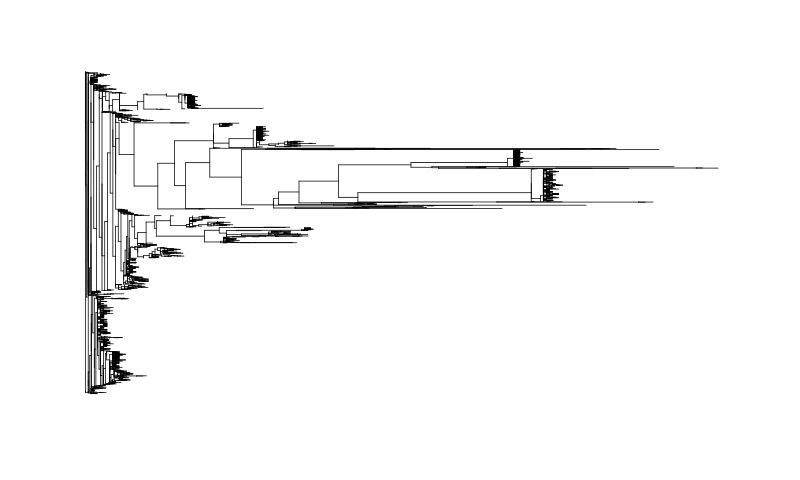

In [113]:
%%R -w 800 -h 480 -u px
library(ape)

otu_tree <- read.tree("RAxML_bestTree.fishpoo_ssu.raxml")
plot(otu_tree, show.tip.label=FALSE)

In [6]:
from rpy2.robjects.packages import importr
import rpy2.robjects as ro

ape = importr('ape')
phytools = importr('phytools')
adephylo = importr('adephylo')
phylobase = importr('phylobase')

# read in the big fish tree
rabosky = ape.read_tree( "host_tree/raboskytree/Rabosky_et_al_timetree.tre" )

# read microbe tree
rep_set = ape.read_tree( "fishpoo_open97/rep_set.tre" )

# compute the list of taxa to drop from the big fish tree
myfishnames  = set(open("host_tree/raboskytree/fish_names.txt").read().split())
allfishnames = set(rabosky.rx('tip.label')[0])
dropnames    = allfishnames.difference(myfishnames)

# drop the fish I don't need
rabosky_trimmed = ape.drop_tip( rabosky, ro.vectors.StrVector( list(dropnames) ) )

# not all of my fish are in the big tree, so we're going to use
# their sister taxa as stand-ins
rabosky_trimmed[2][ rabosky_trimmed[2].index('Neolamprologus_cylindricus')   ] = "Neolamprologus_buescheri"
rabosky_trimmed[2][ rabosky_trimmed[2].index('Cyprichromis_jumbo')           ] = "Cyprichromis_coloratus"
rabosky_trimmed[2][ rabosky_trimmed[2].index('Baileychromis_centropomoides') ] = "Reganochromis_calliurus"
rabosky_trimmed[2][ rabosky_trimmed[2].index('Limnochromis_abeelei')         ] = "Trematochromis_benthicola"

In [7]:
def bloomberg_k( host_tree, trait_table ) :
    ''' Bloomberg's K'''
    phytools.phylosig( host_tree, trait_table, method='K' )[0]

def abouheif_cmean( host_tree, trait_table ) :
    '''Abouheif's Cmean'''
    return adephylo.abouheif_moran( phylobase.phylo4d( host_tree, trait_table ), method="oriAbouheif" )[1][0]

def pagel_lambda( host_tree, trait_table ) :
    '''Pagel's lambda'''
    return map( lambda x : x[0], phytools.phylosig( host_tree, tt, method='lambda' ) )[0]

def moran_i( host_tree, trait_table ) :
    '''Moran's I'''
    return adephylo.abouheif_moran( phylobase.phylo4d( host_tree, tt ), method="Abouheif" )[1][0]
    
tt = ro.vectors.FloatVector( otu_table['HAPLMIC2_37779'] )
tt.names = map( lambda x : x.replace(' ','_'),  otu_table.index )

print 'K : ', bloomberg_k( rabosky_trimmed, tt)
print 'lambda : ', pagel_lambda( rabosky_trimmed, tt ) 
print 'Cmean : ', abouheif_cmean( rabosky_trimmed, tt )
print 'I : ', moran_i( rabosky_trimmed, tt )

K :  None
lambda :  7.96099561485e-05
Cmean :  -0.0976207387486
I :  -0.241811915197


In [8]:
import ProgressBar

Cmean = []
p = ProgressBar.ProgressBar(len(non_rare_otus))
for n,otu in enumerate(non_rare_otus) :
    p.animate(n+1)
    tt = ro.vectors.FloatVector( otu_table[otu] )
    tt.names = map( lambda x : x.replace(' ','_'),  otu_table.index )
    Cmean.append( abouheif_cmean( rabosky_trimmed, tt ) )

[****************100%******************]  1844 of 1844 complete


In [9]:
ttt = ro.vectors.FloatVector( Cmean )
ttt.names = non_rare_otus

# load the tree and convert it into a dichotomous phylogeny
otu_tree = ape.multi2di( ape.read_tree("RAxML_bestTree.fishpoo_ssu.raxml"), random = True )

In [63]:
abouheif_cmean( otu_tree, ttt )
#pagel_lambda( ape.di2multi(otu_tree), ttt )

0.17288801686040056

In [9]:
otu_table[non_rare_otus].to_csv('fishpoo_nonrare_otus.csv')

# For some reason, the RAxML tree dropped a few tips, so
# I guess we'll drop them from the trait table for now.
import dendropy

microbe_tree = dendropy.Tree.get( path='RAxML_bestTree.fishpoo_ssu.raxml', schema='newick')
tips = set(map( lambda x: x.taxon.label.replace(' ','_'), microbe_tree.leaf_nodes() )) & set(non_rare_otus)

#Cmean_df = pd.DataFrame()
#Cmean_df['Cmean'] = Cmean
#Cmean_df.index = non_rare_otus
#Cmean_df.ix[list(tips)].to_csv('fishpoo_nonrare_phylosigs.csv')
with open( 'fishpoo_nonrare_phylosigs.csv', 'w') as f :
    f.write('OTU,Cmean\n')
    for tip in tips :
        f.write( ','.join( ( tip, str(Cmean[ non_rare_otus.index(tip) ]) ) ) + '\n' )

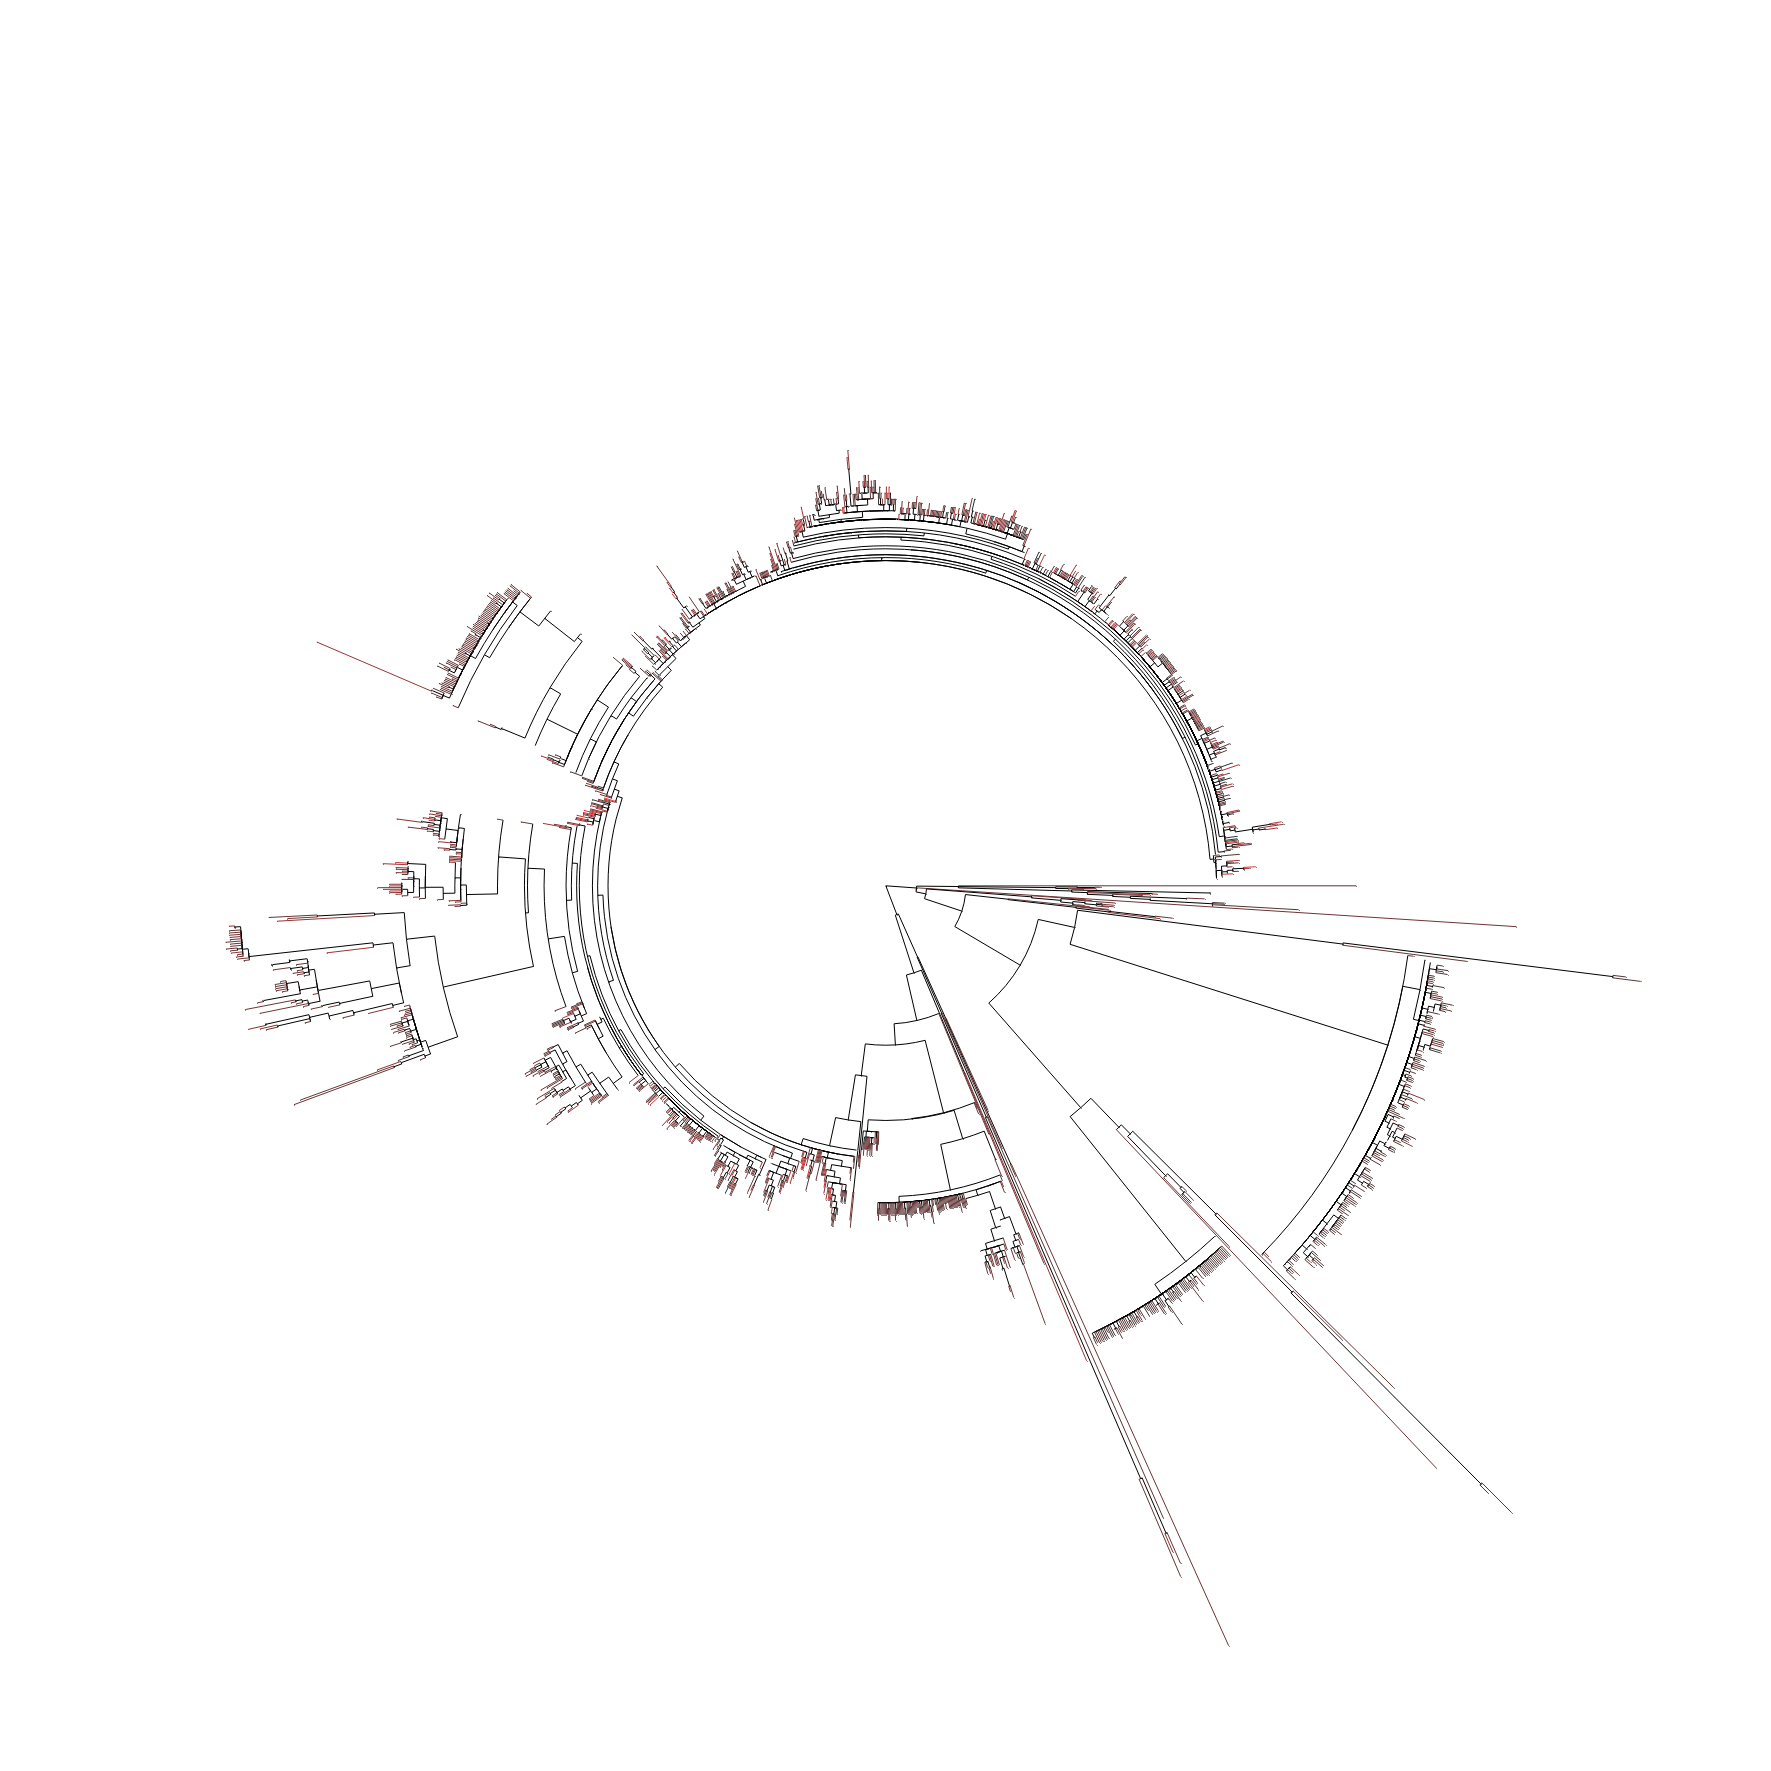

In [30]:
from ete2 import Tree, TreeStyle, NodeStyle
from numpy import linspace

ts = TreeStyle()
#ts.mode = 'r'
ts.mode = 'c'
ts.show_leaf_name = False
ts.branch_vertical_margin = 30
ts.scale = 1000000

t = Tree('RAxML_bestTree.fishpoo_ssu.raxml')
t.set_outgroup( t.get_midpoint_outgroup() ) # balance the unrooted tree

Cmean_dict = dict( zip( non_rare_otus, Cmean ) )

colors = linspace( min(Cmean), max(Cmean), 256 )

for node in t.traverse() :
    if node.is_leaf() :
        nstyle = NodeStyle()
        #nstyle["size"] = 5
        for n in range(256) :
            if colors[n] > Cmean_dict[node.name] : break
        c = '#' + str(hex(n)).split('x')[1] + '3333'
        nstyle["fgcolor"] = c
        #nstyle["bgcolor"] = c
        nstyle["hz_line_color"] = c
        node.set_style(nstyle)
    else :
        nstyle = NodeStyle()
        nstyle["hz_line_color"] = '999999'
        node.set_style(nstyle)
        
t.render("%%inline", w=500, units="mm", tree_style=ts)
#t.render("phylosig-of-phylosig.svg", w=200, units="mm", tree_style=ts)

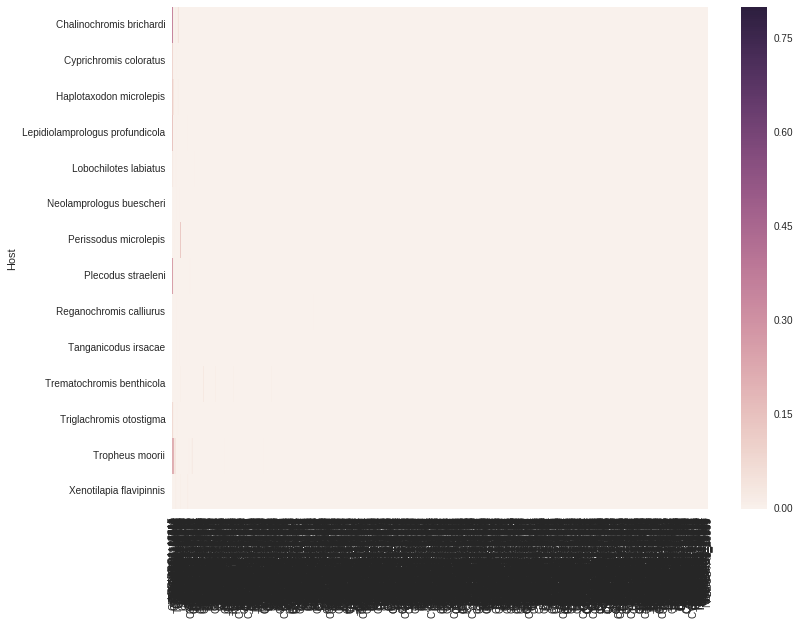

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(otu_table[non_rare_otus], vmax=.8, square=False)

In [33]:
otu_links = otu_table[list(tips)].apply( lambda x : map( int, x > 0.00001 ) )
otu_links.axes[0] = map( lambda x : x.replace(' ','_'), otu_table.axes[0] )
otu_links.to_csv( 'fish-bacteria_links.tsv', sep='\t' )

In [109]:
ape.write_tree(rabosky_trimmed, 'rabosky_trimmed.tre')

rpy2.rinterface.NULL

In [ ]:
from skbio.stats import evolve
import pandas as pd

hostD = pd.read_csv('host_dmatrix.csv')
paraD = pd.read_csv('para_dmatrix.csv')

%time evolve.hommola_cospeciation( hostD, paraD, otu_links.T, permutations=1000 )

In [25]:
shape(hostD), shape(paraD), shape(otu_links.T)

((14, 14), (1841, 1841), (1841, 14))

## Hommola cospeciation

Applying the test to the whole OTU table probably doesn't make sense.
The OTU tree represents a deep sampling of the bacterial tree of life,
which is obviously much older than than the cichlids.

So, what might make morse sense is to grab internal nodes from the OTU
tree, build distance matrixes and link matrixes for them, and then
test for cospeciation. This should give us a Pearson's correlation
for each little bunch of twigs in the microbe tree...

In [68]:
taxon1, taxon2 = microbe_tree.nodes()[5].leaf_nodes()[:2]

dendropy.calculate.treemeasure.patristic_distance( microbe_tree, taxon1.taxon, taxon2.taxon )


0.020439157968021367

In [ ]:
from skbio import TreeNode
from skbio.stats.evolve import hommola_cospeciation

class Cospeciation( object ) :
    def __init__( self, host_tree_file, para_tree_file, links, permutations=2 ) :
        self.host_T = TreeNode.read( host_tree_file )
        self.host_D = self.host_T.tip_tip_distances()
        
        self.para_T = TreeNode.read( para_tree_file )
        self.para_D = self.para_T.tip_tip_distances()
        
        self.links  = links
        self.permutations = permutations
    def hommola_subtree( self, node ) :
        leafs = node.subset()
        PD = self.para_D.filter( leafs )
        if PD.shape[0] < 3 : return None
        return hommola_cospeciation( self.host_D, 
                                     self.para_D.filter( leafs ), 
                                     self.links[ [ name.replace(' ','_') for name in list(leafs) ] ].T, 
                                     permutations=self.permutations )

CS = Cospeciation( 'rabosky_trimmed.tre', 'RAxML_bestTree.fishpoo_ssu.raxml', otu_links )

internal_nodes = []
for n,node in enumerate(CS.para_T.non_tips()) :
    if n > 10 : break
    internal_nodes.append( node )
print map( CS.hommola_subtree, internal_nodes )

In [38]:
import cPickle
from ipyparallel import Client

c = Client(profile='default')
v = c[:]

cPickle.dump( CS.host_D, open( '/tmp/host_dmatrix.pickle', 'w' ) )
cPickle.dump( CS.para_D, open( '/tmp/para_dmatrix.pickle', 'w' ) )
cPickle.dump( CS.links,  open( '/tmp/fish-bacteria_links.pickle', 'w') )

def parallel_hommola( node ) :
    import cPickle
    from skbio import TreeNode
    from skbio.stats.evolve import hommola_cospeciation
    host_D = cPickle.load( open( '/tmp/host_dmatrix.pickle' ) )
    para_D = cPickle.load( open( '/tmp/para_dmatrix.pickle' ) )
    links  = cPickle.load( open( '/tmp/fish-bacteria_links.pickle' ) )
    leafs = node.subset()
    PD = para_D.filter( leafs )
    if PD.shape[0] < 3 : return None
    return hommola_cospeciation( host_D, 
                                 para_D.filter( leafs ), 
                                 links[ [ name.replace(' ','_') for name in list(leafs) ] ].T, 
                                 permutations=1000 )
internal_nodes = []
for n,node in enumerate(CS.para_T.non_tips()) :
    #if n > 10 : break
    internal_nodes.append( node )

results = v.map( parallel_hommola, internal_nodes )

In [89]:
results.ready()

True

In [121]:
import cPickle

homolla_clades = zip( internal_nodes, results.result )
cPickle.dump( homolla_clades, open( 'hommolla_clades.pickle', 'w') )

In [11]:
import cPickle

homolla_clades = cPickle.load( open( 'hommolla_clades.pickle' ) )

# Pearson correlation coefficient of host-parasite association

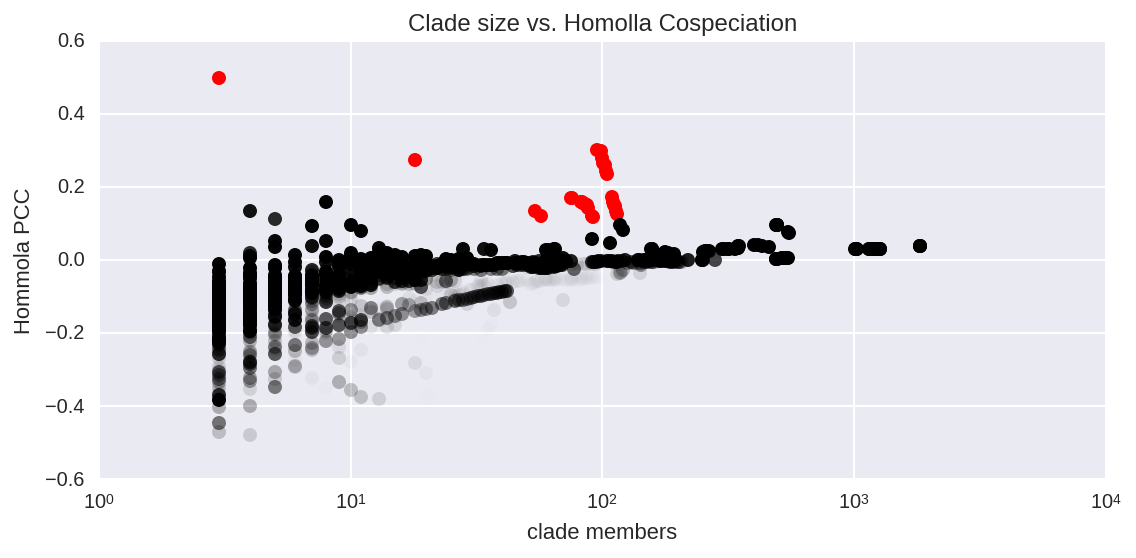

In [15]:
import seaborn

figure(figsize=(8, 4))
C = []
#subplot(1,2,1)
for node, hommola_result in homolla_clades :
    if hommola_result :
        pcc = hommola_result[0]
        size = sum( 1 for i in node.tips())
        if pcc > 0.2 : 
            color = 'red'
        elif pcc > 0.1 and size > 50 :
            color = 'red'
        else :
            color = 'black'
        
        C.append( pcc )
        plot( size, pcc, 
              alpha = 1-hommola_result[1],
              marker='o',
              color=color )
semilogx()
title( 'Clade size vs. Homolla Cospeciation')
xlabel( 'clade members' )
ylabel( 'Hommola PCC' )

#subplot(1,2,2)
#plot(C)
#title( 'Clade position vs. Homolla Cospeciation')
#xlabel( 'clade position in OTU tree' )
#ylabel( 'Hommola PCC' )

tight_layout()

In [261]:
for node,pcc in sorted( filter( lambda x : x[1], homolla_clades ), key = lambda x : x[1][0], reverse=True )[:20] :
    print sum( 1 for i in node.tips()), pcc[0], pcc[1]

3 0.498198134331 0.002997002997
95 0.299769477803 0.001998001998
99 0.298903289434 0.000999000999001
100 0.27910553012 0.000999000999001
18 0.273209454685 0.001998001998
101 0.265381449372 0.000999000999001
102 0.261096640249 0.000999000999001
103 0.242081325525 0.000999000999001
104 0.233917327144 0.000999000999001
109 0.17145657516 0.000999000999001
75 0.16956219775 0.015984015984
76 0.169554888446 0.010989010989
82 0.159186745376 0.016983016983
110 0.158911721541 0.000999000999001
83 0.157641281401 0.00699300699301
8 0.15755217159 0.002997002997
84 0.154827156016 0.012987012987
85 0.153163851537 0.014985014985
86 0.151767631687 0.012987012987
111 0.149643638141 0.000999000999001


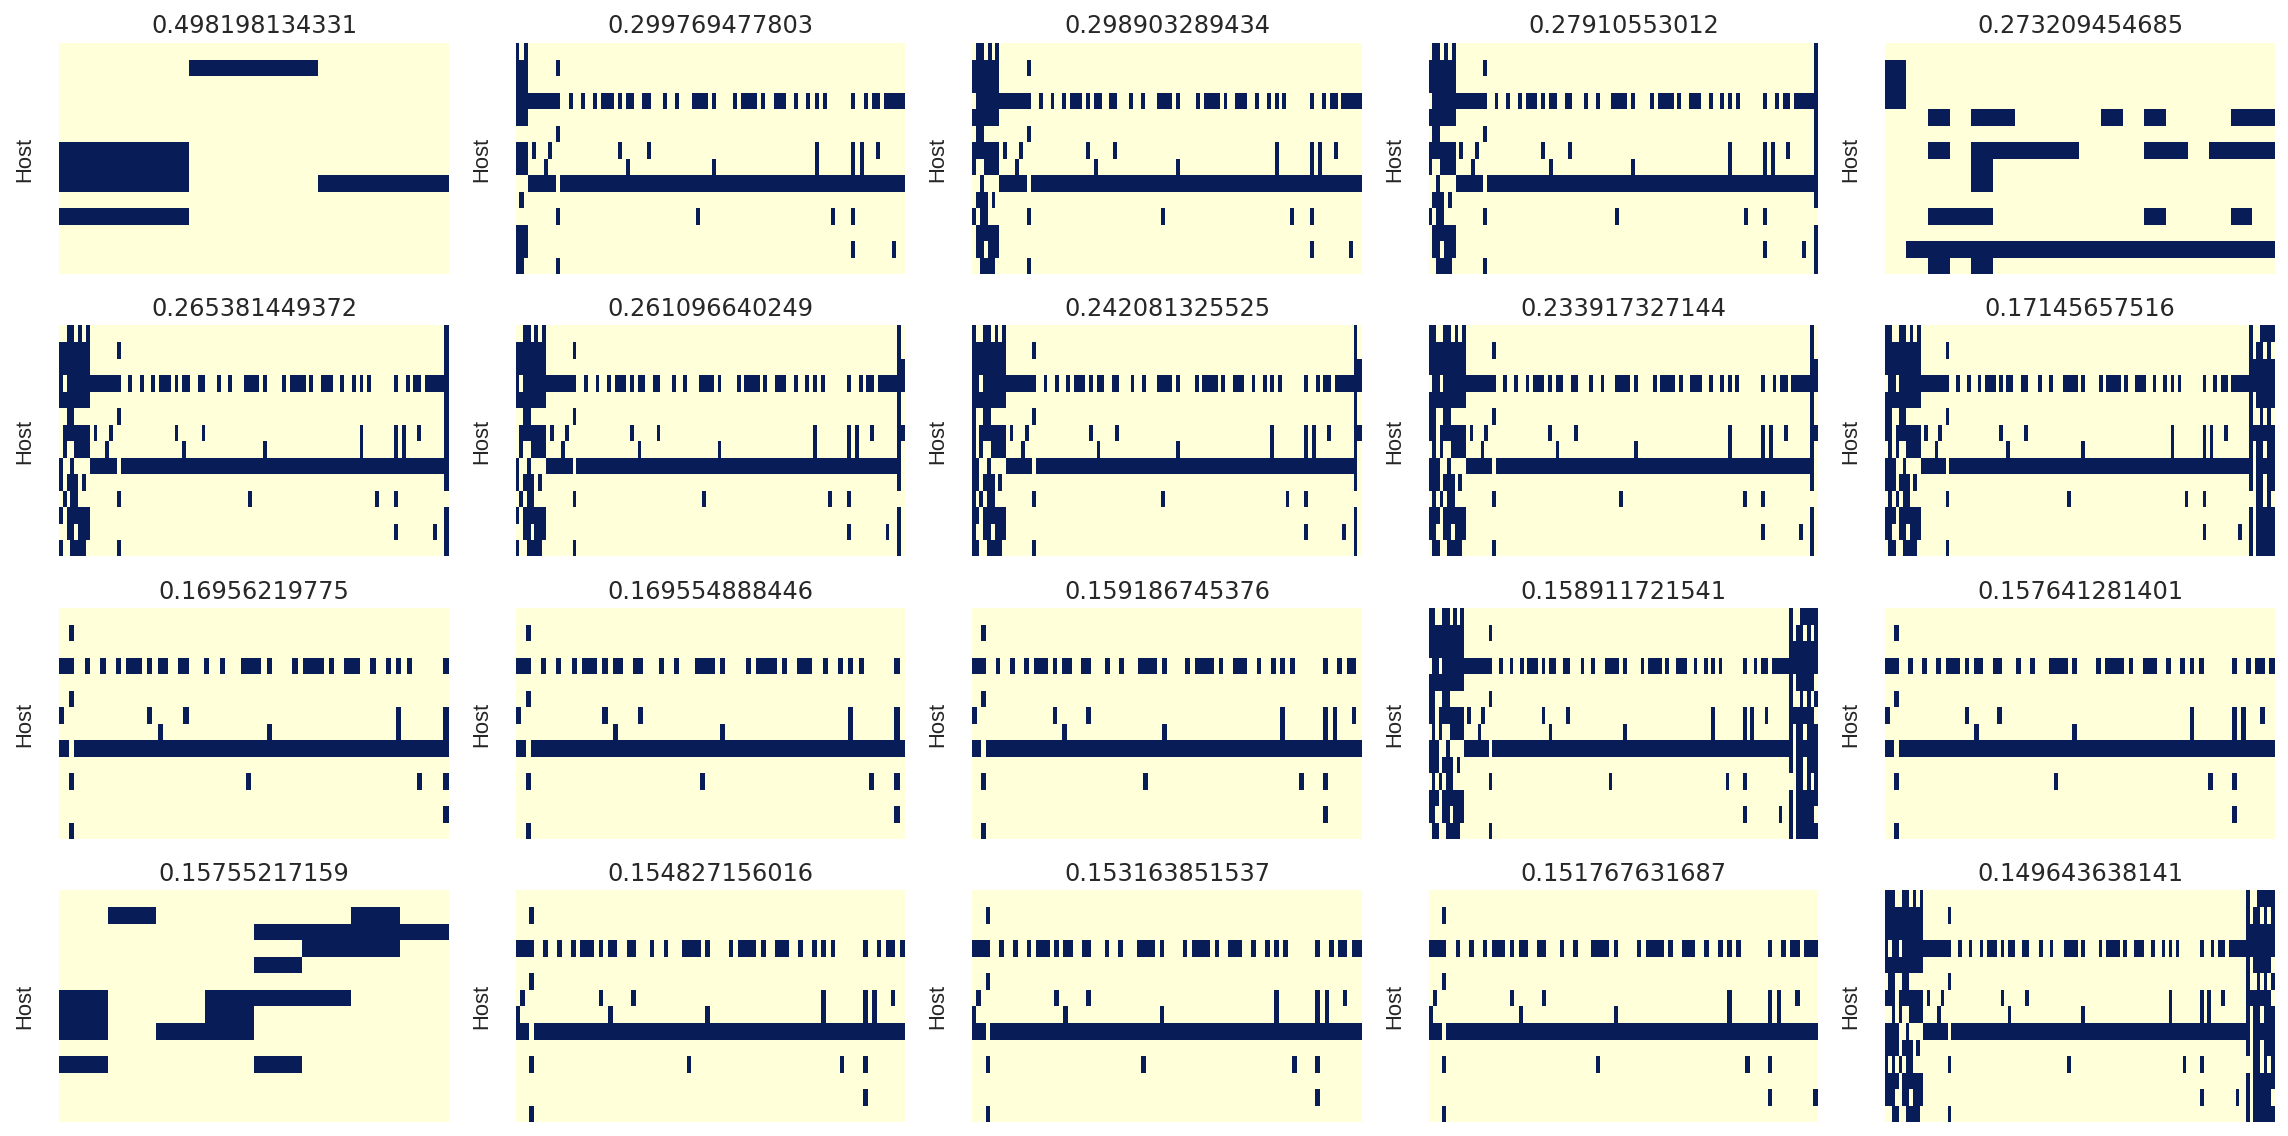

In [229]:
import seaborn

figure(figsize=(16, 8))
for n,d in enumerate( sorted( filter( lambda x : x[1], homolla_clades ), key = lambda x : x[1][0], reverse=True ) ) :
    if n == 20 : break
    subplot(4,5,n+1)
    #d[0].tip_tip_distances().plot()
    title( d[1][0] )
    seaborn.heatmap( otu_links[ [ tip.name.replace(' ','_') for tip in d[0].tips() ] ],
                     xticklabels = False,
                     yticklabels = False,
                     cbar = False,
                     cmap="YlGnBu" )

tight_layout()

[u'CYPRCOL1 20788', u'CHALBRI.2 110265', u'CHALBRI.2 10198', u'x15625.45 222', u'HAPMIC6.2 59238', u'CHALBRI.2 118490', u'CHALBRI.2 100104', u'HAPMIC1.2 64814', u'CHALBRI.2 40748', u'HAPMIC6.2 6834', u'CHALBRI.2 106342', u'HAPMIC6.2 14537', u'CHALBRI.2 112655', u'CHALBRI.2 100434', u'HAPMIC6.2 42212', u'CHALBRI.2 115808', u'TRIGOTO3.2 56575', u'CHALBRI.2 59388']


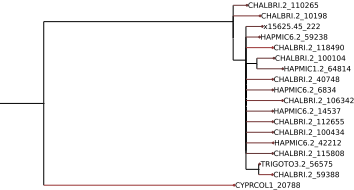

In [260]:
from ete2 import Tree, TreeStyle, NodeStyle, faces, AttrFace
from numpy import linspace

t = sorted( filter( lambda x : x[1], homolla_clades ), key = lambda x : x[1][0], reverse=True )[4][0]

t.write( 'some_clade.tre' )
print [tip.name for tip in t.tips()]

ts = TreeStyle()
ts.mode = 'r'
#ts.mode = 'c'
ts.show_leaf_name = True
ts.branch_vertical_margin = 1000
ts.scale = 1000000

t = Tree('some_clade.tre')
t.set_outgroup( t.get_midpoint_outgroup() ) # balance the unrooted tree

Cmean_dict = dict( zip( non_rare_otus, Cmean ) )

colors = linspace( min(Cmean), max(Cmean), 256 )

for node in t.traverse() :
    if node.is_leaf() :
        nstyle = NodeStyle()
        nstyle["size"] = 1000
        for n in range(256) :
            if colors[n] > Cmean_dict[node.name] : break
        c = '#' + str(hex(n)).split('x')[1] + '3333'
        nstyle["fgcolor"] = c
        #nstyle["bgcolor"] = c
        nstyle["hz_line_color"] = c
        N = AttrFace("name", fsize=1400, fgcolor="black")
        node.add_face(N,0)
        node.set_style(nstyle)
    else :
        nstyle = NodeStyle()
        nstyle["hz_line_color"] = '999999'
        node.set_style(nstyle)
        
t.render("%%inline", w=100, units="mm", tree_style=ts)

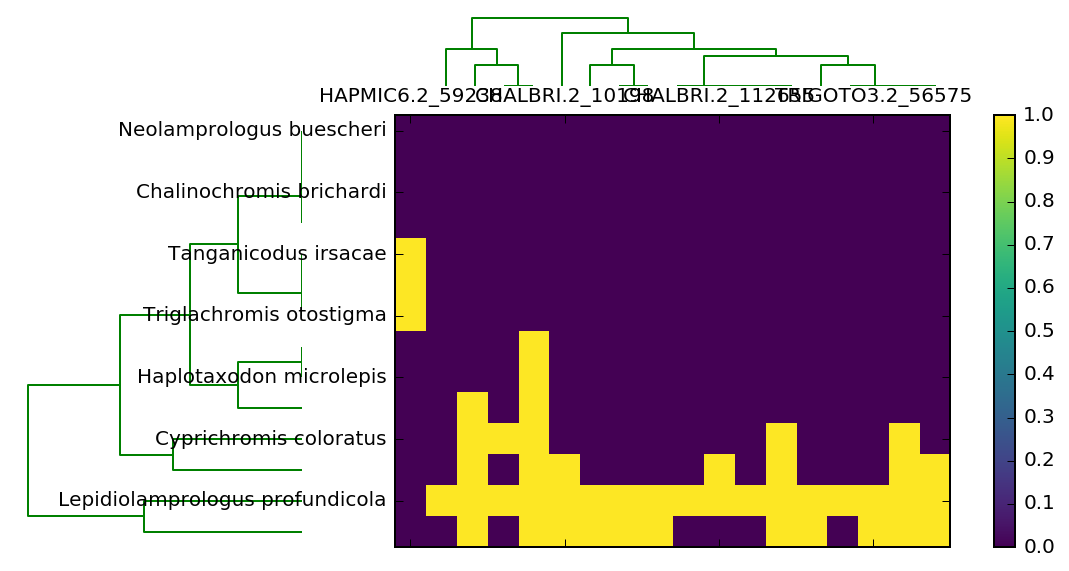

In [34]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist,squareform
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

d = sorted( filter( lambda x : x[1], homolla_clades ), key = lambda x : x[1][0], reverse=True )[4]
df = otu_links[ [ tip.name.replace(' ','_') for tip in d[0].tips() ] ]
ts
# Compute pairwise distances for rows
row_clusters = linkage(df.values, method='complete', metric='euclidean')

# Compute pairwise distances for columns
col_dists = pdist(df.T, metric='euclidean')
col_clusters = linkage(col_dists, method='complete')

# plot column dendrogram
fig = plt.figure(figsize=(10,5))

axd2 = fig.add_axes([0.38,0.74,0.36,0.10]) 
col_dendr = dendrogram(col_clusters, orientation='top',
                       color_threshold=np.inf) # makes dendrogram black)
axd2.set_xticks([])
axd2.set_yticks([])

# plot row dendrogram
axd1 = fig.add_axes([0.09,0.1,0.2,0.6])
row_dendr = dendrogram(row_clusters, orientation='right',  
                       count_sort='ascending',
                       color_threshold=np.inf) # makes dendrogram black
axd1.set_xticks([])
axd1.set_yticks([])

# remove axes spines from dendrogram
for i,j in zip(axd1.spines.values(), axd2.spines.values()):
        i.set_visible(False)
        j.set_visible(False)
        

# reorder columns and rows with respect to the clustering
df_rowclust = df.ix[row_dendr['leaves'][::-1]]
df_rowclust.columns = [df_rowclust.columns[col_dendr['leaves']]]

# plot heatmap
axm = fig.add_axes([0.26,0.1,0.6,0.6])
cax = axm.matshow(df_rowclust, interpolation='nearest', cmap='viridis')
fig.colorbar(cax)
axm.set_xticklabels([''] + list(df_rowclust.columns))
axm.set_yticklabels([''] + list(df_rowclust.index))

plt.show()

In [31]:
"""
A 4 by (n−1) matrix Z is returned. At the i-th iteration, clusters with indices Z[i, 0] and Z[i, 1] are combined to form cluster n+i. A cluster with an index less than n corresponds to one of the n original observations. The distance between clusters Z[i, 0] and Z[i, 1] is given by Z[i, 2]. The fourth value Z[i, 3] represents the number of original observations in the newly formed cluster.
"""
for n,i in enumerate(linkage(df.values)) :
    print n,i

0 [ 0.  9.  0.  2.]
1 [  5.  14.   0.   3.]
2 [  1.10000000e+01   1.50000000e+01   4.25347361e-06   4.00000000e+00]
3 [  1.00000000e+00   2.00000000e+00   8.20813848e-06   2.00000000e+00]
4 [  3.00000000e+00   1.60000000e+01   1.55697211e-05   5.00000000e+00]
5 [  7.00000000e+00   1.80000000e+01   1.76824249e-05   6.00000000e+00]
6 [  8.00000000e+00   1.90000000e+01   4.11636359e-05   7.00000000e+00]
7 [  1.70000000e+01   2.00000000e+01   6.53860153e-05   9.00000000e+00]
8 [  1.00000000e+01   1.30000000e+01   1.27874963e-04   2.00000000e+00]
9 [  2.10000000e+01   2.20000000e+01   1.43337344e-04   1.10000000e+01]
10 [  4.00000000e+00   2.30000000e+01   1.12625095e-03   1.20000000e+01]
11 [  6.00000000e+00   2.40000000e+01   2.53907696e-03   1.30000000e+01]
12 [ 12.          25.           0.03325614  14.        ]


In [29]:
import skbio

t = skbio.tree.TreeNode.read( 'RAxML_bestTree.fishpoo_ssu.raxml' )

for tip in t.tips() :
    if not len(tip.siblings()) == 1 :
        print tip, tip.siblings()

LEPIPRO1_18315:1.00000050003e-06;
 [<TreeNode, name: unnamed, internal node count: 13, tips count: 15>, <TreeNode, name: unnamed, internal node count: 1823, tips count: 1825>]


In [26]:
dendrogram??